In [ ]:
def merge_log():
    """
    ./logs의 모든 로그를 (알고리즘, 환경) 별로 모아서 저장
    """

    import os, time
    import pandas as pd
    from collections import defaultdict

    PATH = os.path.join(os.getcwd(), 'logs')
    filename_list = ['.'.join(tokens[:-1]) 
                        for name in os.listdir(PATH) 
                        if (tokens := name.split('.')) and len(tokens) > 2]
    fileinfo_list = [name.split('_')[:2] for name in filename_list]
    list(map(lambda x:x.split('_')[:2], filename_list))

    cases = defaultdict(list)

    for (algo, env), filename in zip(fileinfo_list, filename_list):
        load_path = os.path.join(PATH, filename) + '.csv'
        save_path = os.path.join(PATH, f'{algo}_{env}_{int(time.time())}') + '.csv'
        cases[save_path].append(load_path)

    count = defaultdict(int)

    for save_path in cases:
        outp = pd.DataFrame()
        
        for load_path in cases[save_path]:
            print(save_path)
            print(f'로드: {load_path}')
            inp = pd.read_csv(load_path)
            last_epi = inp['episode'].max()
            inp['episode'] += count[save_path]
            print(count[save_path])
            count[save_path] += last_epi + 1
            
            outp = pd.concat([outp, inp])

        outp.to_csv(save_path, index=False, encoding='utf-8')
    

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

def draw_corr_mat_heatmap(dataframe, *, figsize=(10, 10), drop_columns=[]):
    
    dataframe.drop(columns=drop_columns, inplace=True) # 지정된 열을 삭제
    corr_df = dataframe.corr() # 쌍별 상관관계 행렬
    fig, ax = plt.subplots(figsize=figsize)

    # 원소가 1인 상부삼각행렬
    masked = np.zeros_like(corr_df, dtype=np.bool)
    masked[np.triu_indices_from(masked)] = True

    sns.heatmap(
        corr_df,
        cmap=sns.color_palette("RdBu", 10),
        annot=True,  # 실제 값을 표시한다
        mask=masked,  # 숨길 위치 = True
        linewidths=.5,  # 셀의 경계선 너비
        cbar_kws={"shrink": .5},  # 컬러바 크기 설정
        vmin=-1, # 컬러바 범위 설정 [-1, 1]
        vmax=1  
    )

    plt.title('Correation Matrix', fontsize=20)
    plt.show()

def visualize(df, *, figsize=(5, 5), graph_drop_cols=['reward', 'done', 'step'], corr_drop_cols=['reward', 'done', 'action', 'episode', 'step']):
    sns.set_palette("pastel")
    plt.figure(figsize=figsize) # 피규어 생성
    df_group_by = df.groupby(by='episode') # 'episode' 레이블로 그룹화
    max_steps = df_group_by["step"].max() # 각 그룹에서 'step' 레이블의 max를 구함
    max_step_df = pd.DataFrame(max_steps) # step의 max값으로 df를 만든다.
    max_step_df.reset_index(inplace=True)

    plt.title("max step histogram")
    sns.histplot(data=max_step_df, x=max_step_df.step) # 히스토그램 출력
    plt.show()

    draw_corr_mat_heatmap(df, drop_columns=corr_drop_cols) # 상관관계행렬 heatmap 출력

    # 그래프
    col_names = [col for col in df.columns.to_list() if col not in set(graph_drop_cols)]

    for col in col_names:
        fig, ax = plt.subplots(figsize=figsize)
        sns.histplot(x=df[col])



In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

def load_log(filename):
    df = pd.read_csv(f"./logs/{filename}.csv")
    env_name = filename.split('_')[1].split('-')[0]
    if env_name == 'CartPole':
        df.rename(columns = {
            'state0' : 'Cart Position',
            'state1' : 'Cart Velocity',
            'state2' : 'Pole Angle',
            'state3' : 'Pole Angular Velocity'
            }, inplace = True)
    elif env_name == 'LunarLander':
        df.rename(columns = {
            'state0' : 'Horizontal Coord',
            'state1' : 'Vertical Coord',
            'state2' : 'Horizontal Speed',
            'state3' : 'Vertical Speed',
            'state4' : 'Angle',
            'state5' : 'Angular Speed',
            'state6' : 'First Leg',
            'state7' : 'Second Leg'
            }, inplace = True)
    return df

# df = load_log('ActorCritic_LunarLander-v2_1635373522')
# sns.set_style('whitegrid')

# fig = plt.figure(figsize=(10, 5))
# area1 = fig.add_subplot(1, 3, 1)
# area2 = fig.add_subplot(1, 3, 2)
# fig.show()

def demo():
    df = load_log('ActorCritic_LunarLander-v2_1635373522')
    df = df.drop(['reward', 'episode', 'done'], axis=1)
    print(f'데이터 개수: {len(df)}')


    def dim1():
        """
        실수 분포 플롯은 자료의 분포를 묘사하기 위한 것으로 Matplotlib의 단순한 히스토그램과 달리 
        커널 밀도(kernel density) 및 러그(rug) 표시 기능 및 다차원 복합 분포 기능 등을 제공한다. 
        1차원 실수 분포 플롯 명령에는 rugplot, kdeplot, distplot이 있다.

        러그(rug) 플롯은 데이터 위치를 x축 위에 작은 선분(rug)으로 나타내어 실제 데이터들의 위치를 보여준다.
        """
        data = df['Angular Speed']
        sns.rugplot(data) # 데이터 위치 표시
        plt.title("Angular Speed")
        plt.show()

        sns.kdeplot(data) # 커널 밀도 표시 (히스토그램보다 부드러운 형태의 분포 곡선)
        plt.title("Angular Speed")
        plt.show()

        sns.distplot(data, kde=True, rug=True)
        plt.title("Angular Speed")
        plt.show()

        """
        countplot 명령을 사용하면 각 카테고리 값별로 데이터가 얼마나 있는지 표시할 수 있다.
        countplot 명령은 데이터프레임에만 사용할 수 있다. 사용 방법은 다음과 같다.
        data 인수에는 대상이 되는 데이터프레임을, x 인수에는 데이터프레임의 열 이름 문자열을 넣는다.
        """
        sns.countplot(x="action", data=df)
        plt.title("action")
        plt.show()
    
    def dim2():
        """
        분석하고자 하는 데이터가 2차원이고 실수 값인 경우
        """
        df2 = df.loc[df['episode'] == 1]
        x_feat, y_feat = "step", "Angle"
        sns.jointplot(x=x_feat, y=y_feat, data=df2, kind="scatter")
        plt.suptitle("2d jointplot", y=1.02)
        plt.show()

        # kernel density의 경우 시간초과
        # sns.jointplot(x=x_feat, y=y_feat, data=df[:10000], kind="kde")
        # plt.suptitle("2d jointplot kernel density", y=1.02)
        # plt.show()

        sns.barplot(x='action', y=y_feat, data=df2)
        plt.title("2d barplot")
        plt.show()

    def dimn():
        """
        3차원 이상의 실수 데이터
        """
        # sns.pairplot(df, corner=True)
        # plt.title("pairplot")
        # plt.show()
        # """
        # 3차원 이상의 실수 데이터
        # """
        # g = sns.pairplot(df, diag_kind="kde", corner=True)
        # g.map_lower(sns.kdeplot, levels=4, color=".2")
        # """
        # 3차원 이상의 실수-카테고리 데이터
        # """
        # sns.pairplot(df, hue="action", corner=True)
        # plt.title("pairplot")
        # plt.show()

        sns.pairplot(df, kind="hist", corner=True)
        
    def demo_pandas():
        df.drop(['step'], axis=1).plot.box()
        plt.title("hist Box Plot")
        plt.xlabel("Feature")
        plt.ylabel("value")
        plt.show()

    dim2()

demo()

데이터 개수: 760799


KeyError: 'episode'

ActorCritic_CartPole-v1_1635373522


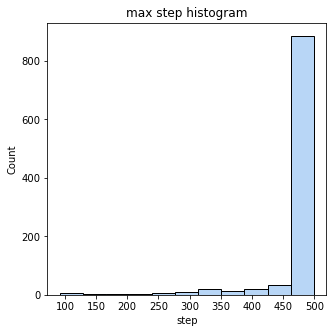

C:\Users\kuro1\AppData\Local\Temp/ipykernel_24652/1273148140.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros_like(corr_df, dtype=np.bool)


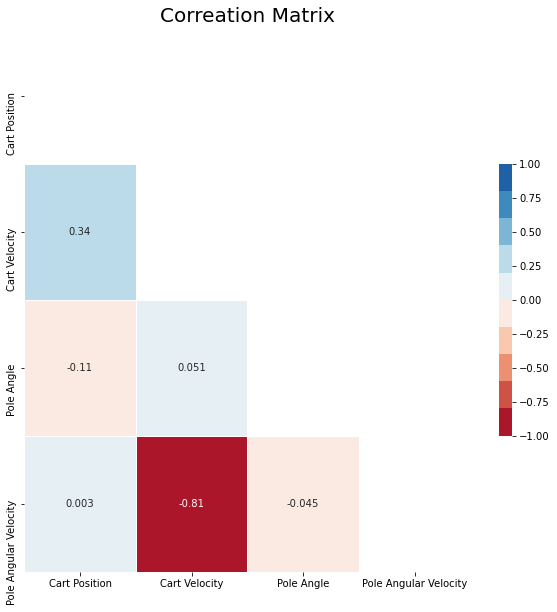

ActorCritic_LunarLander-v2_1635373522


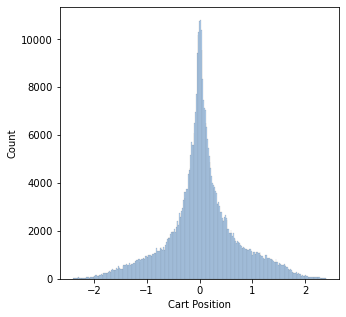

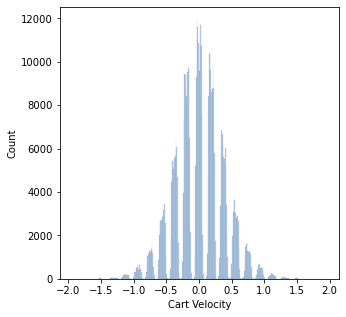

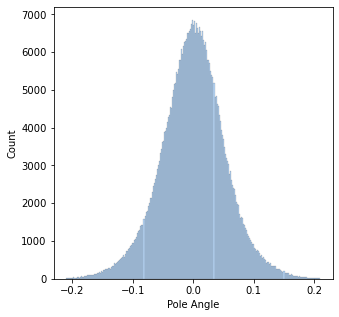

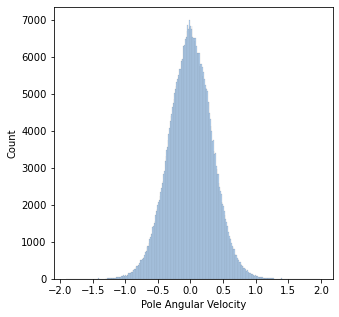

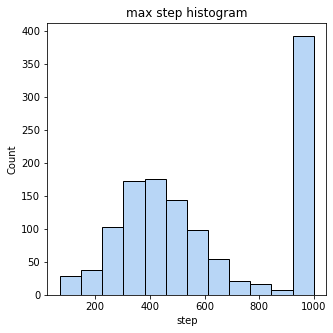

C:\Users\kuro1\AppData\Local\Temp/ipykernel_24652/1273148140.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros_like(corr_df, dtype=np.bool)


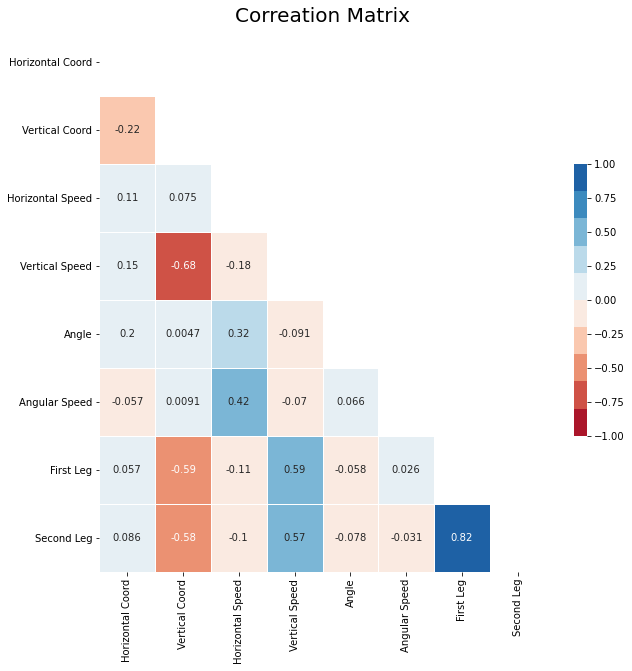

DDQN_CartPole-v1_1635373522


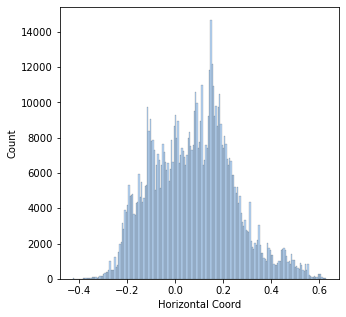

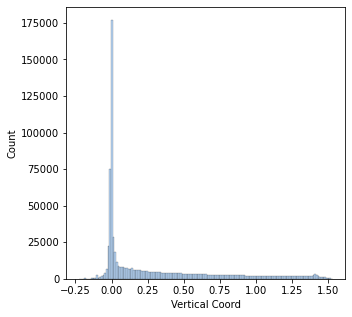

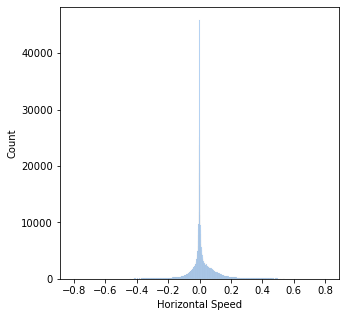

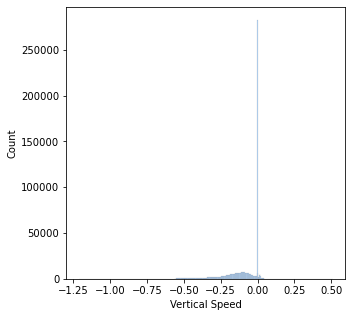

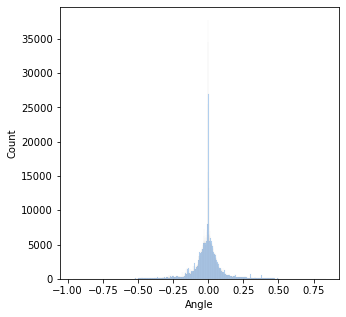

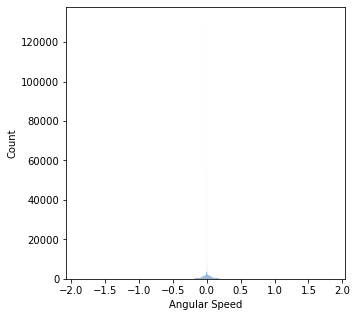

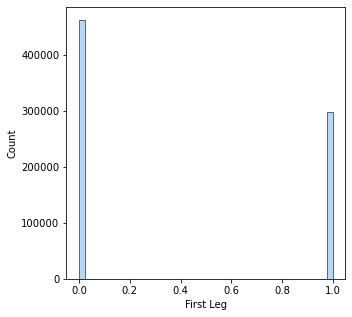

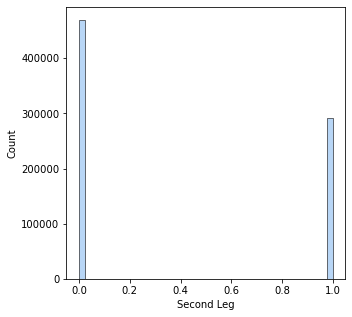

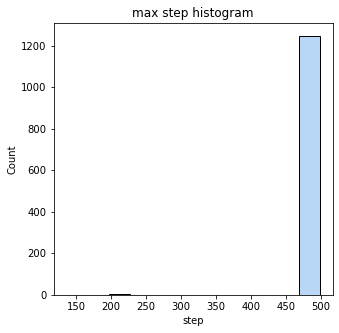

C:\Users\kuro1\AppData\Local\Temp/ipykernel_24652/1273148140.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros_like(corr_df, dtype=np.bool)


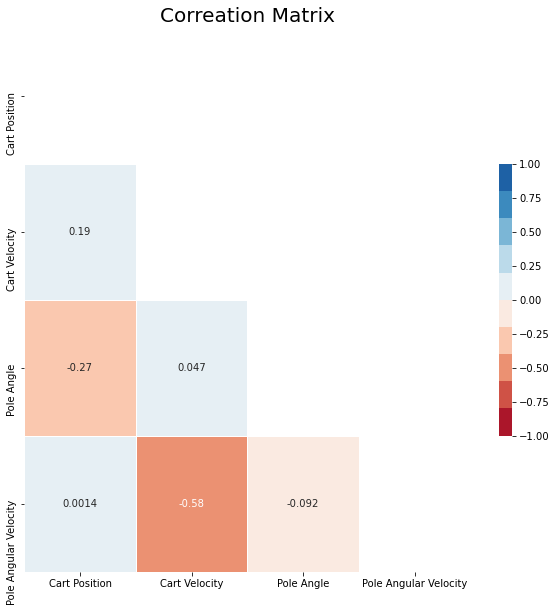

DDQN_LunarLander-v2_1635373522


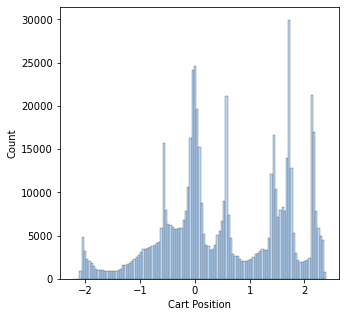

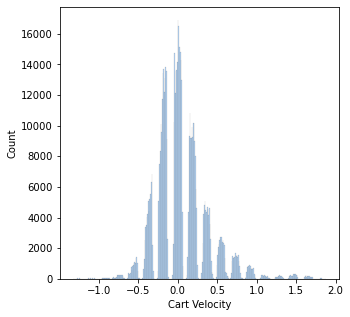

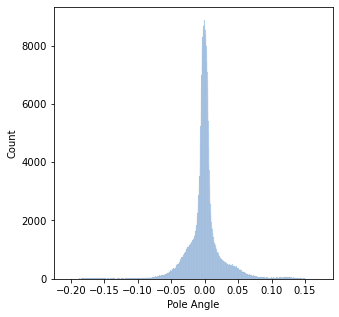

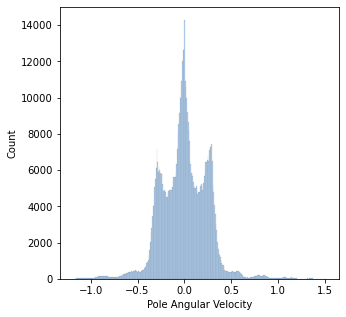

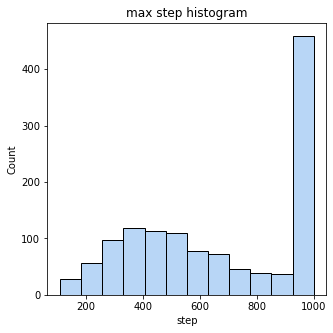

C:\Users\kuro1\AppData\Local\Temp/ipykernel_24652/1273148140.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros_like(corr_df, dtype=np.bool)


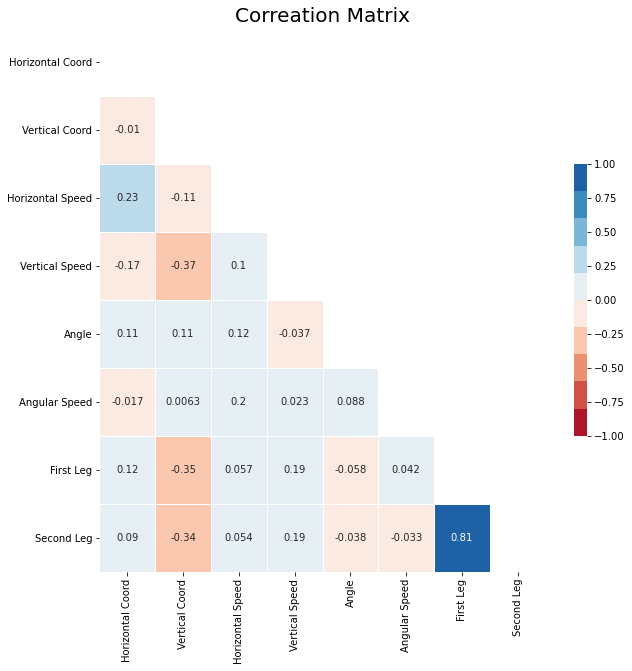

DQN_CartPole-v1_1635373522


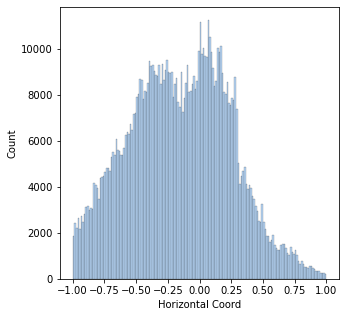

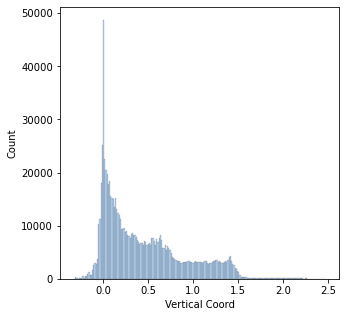

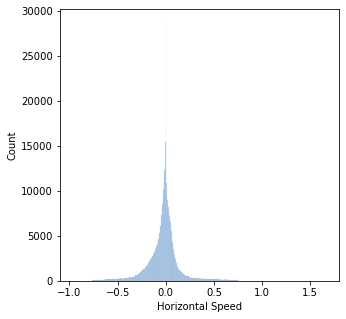

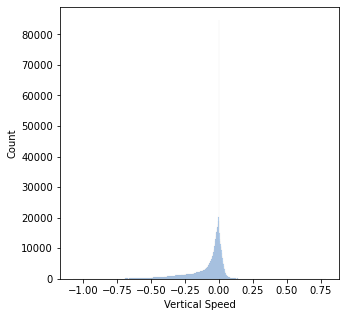

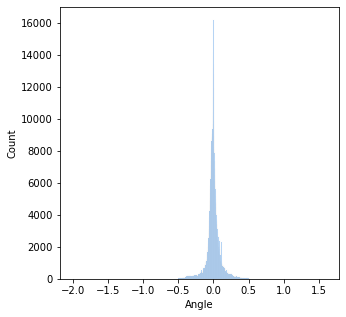

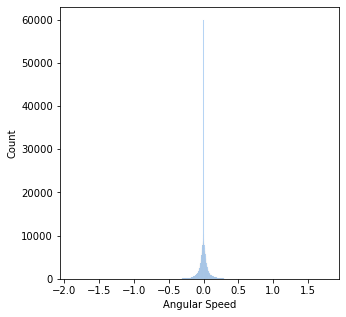

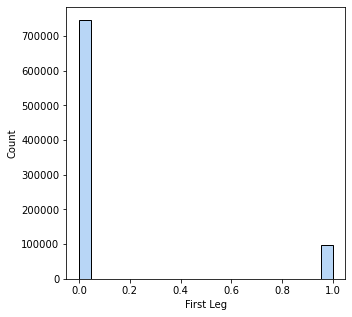

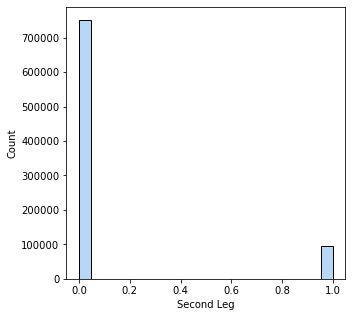

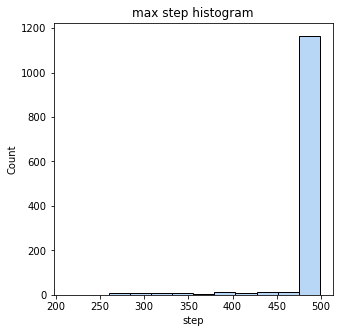

C:\Users\kuro1\AppData\Local\Temp/ipykernel_24652/1273148140.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros_like(corr_df, dtype=np.bool)


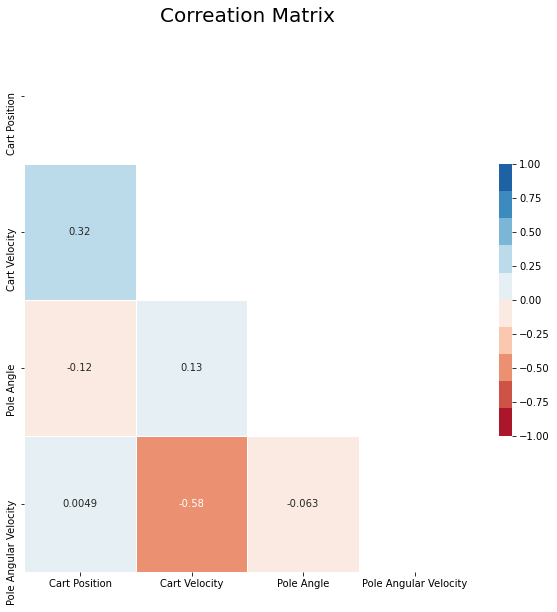

DQN_LunarLander-v2_1635373522


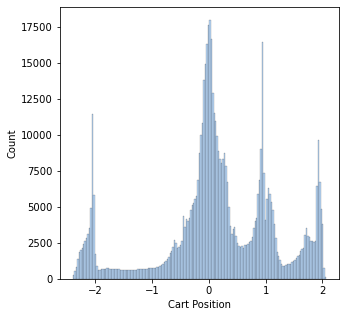

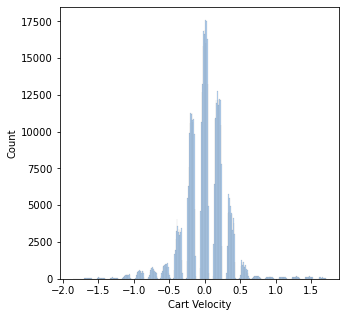

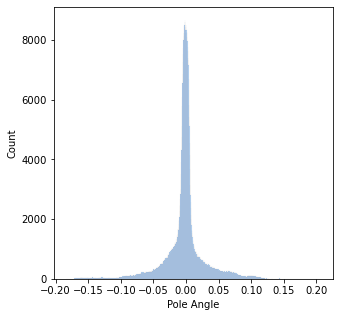

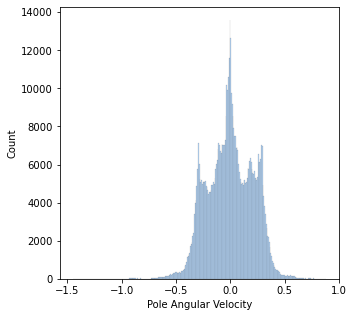

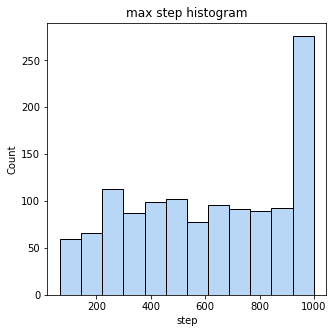

C:\Users\kuro1\AppData\Local\Temp/ipykernel_24652/1273148140.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked = np.zeros_like(corr_df, dtype=np.bool)


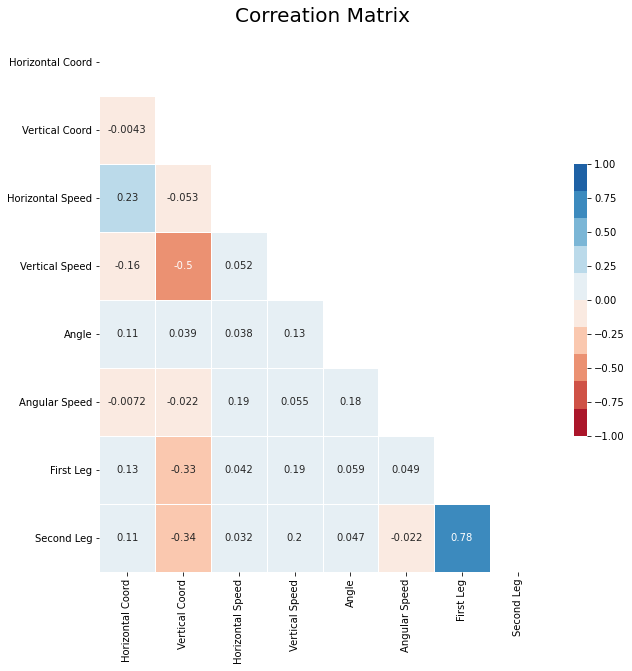

Reinforce_CartPole-v1_1635373522


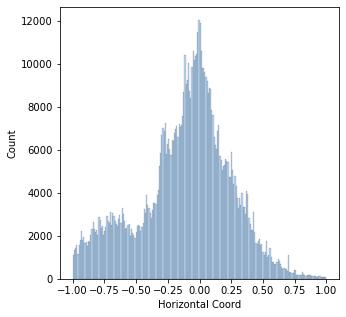

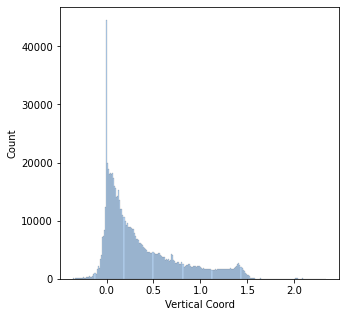

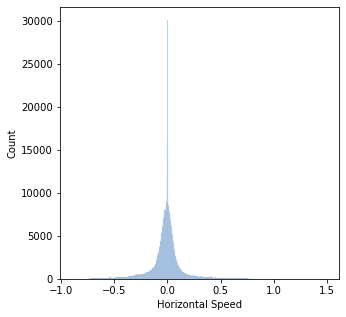

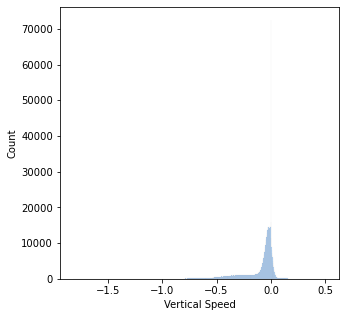

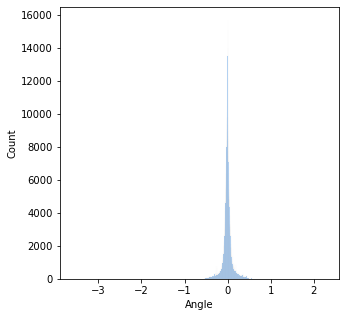

In [16]:


def print_statistics():
    cases = dict()
    cases["CartPole-v1"] = [
        "DQN_CartPole-v1_train=False_intvl=1_rwdscl=1.0_node=128_lRate=0.0005_gma=0.98_nBuf=50000_nBat=32_nStrt=2000_updIntvl=10_1635102083"]
    # cases["LunarLander-v2"] = [
    #     "Reinforce_LunarLander-v2_train=False_intvl=1_rwdscl=1.0_node=256_lRate=0.0025_gma=0.98_1634919662",
    #     "ActorCritic_LunarLander-v2_train=False_intvl=1_rwdscl=1.0_node=256_lRate=0.0025_gma=0.98_nRoll=20_1634920427",
    #     "DQN_LunarLander-v2_train=False_intvl=1_rwdscl=1.0_node=256_lRate=0.0005_gma=0.98_nBuf=100000_nBat=64_nStrt=10000_updIntvl=20_1634920703",
    #     "DDQN_LunarLander-v2_train=False_intvl=1_rwdscl=1.0_node=256_lRate=0.0005_gma=0.98_nBuf=100000_nBat=64_nStrt=10000_updIntvl=20_1634921263"]

    for env in cases:
        print(f'\n\t<<{env}>>')
        feature_data_list = defaultdict(pd.DataFrame)
        for filename in cases[env]:
            print(filename)
            algo = filename.split('_')[0]
            df = load_log(filename)
            for col in df.columns:
                sr = df[[col]].squeeze()
                sr.rename(algo, inplace=True)
                feature_data_list[col] = pd.concat([feature_data_list[col], sr], axis=1)
        for feature in feature_data_list:
            print(f'\n\t<{feature}>')
            df_stats = feature_data_list[feature].describe()
            print(df_stats)

def get_compare_statics(env_algo_dic):
    statics = dict()
    for env, algo_dic in env_algo_dic.items():
        statics[env] = statics.get(env, defaultdict(pd.DataFrame))
        for algo, df in algo_dic.items():
            describe = df.describe()
            for col in describe.columns:
                sr = describe[[col]].squeeze()
                sr.rename(algo, inplace=True)
                statics[env][col] = pd.concat([statics[env][col], sr], axis=1)
    return statics

def main():
    PATH = os.path.join(os.getcwd(), 'logs')
    filenames = []
    for name in os.listdir(PATH):
        tokens = [*name.split('.')]
        filename = None
        if len(tokens) > 2:
            filename = '.'.join(tokens[:-1])
        else:
            filename = tokens[0]

        filenames.append(filename)
    

    dfs = list(map(load_log, filenames))

    def compare():
        env_algo_dic = dict()
        
        # 에피소드별 최종 스텝 추가 필요
        for df, filename in zip(dfs, filenames):
            tokens = filename.split('_')
            algo, env, *_ = tokens
            env_algo_dic[env] = env_algo_dic.get(env, dict())

            if algo in env_algo_dic[env]:
                env_algo_dic[env][algo] = pd.concat([env_algo_dic[env][algo], df])
            else:
                env_algo_dic[env][algo] = df

        statics = get_compare_statics(env_algo_dic)
        for env in statics:
            for feature in statics[env]:
                print(f'{env}, {feature}')
                print(statics[env][feature])
                print()
            print()

    def visual():
        for df, filename in zip(dfs, filenames):
            print(filename)
            visualize(df)

    visual()
    
main()

In [ ]:
df.groupby(by='episode')["step"].describe()

In [ ]:
step_value = pd.DataFrame(df.groupby(by='episode')["step"].max())
step_value.reset_index(inplace=True)
step_value

In [ ]:
sns.histplot(data=step_value,x=step_value.step,bins=5)

In [ ]:
plt.title("last step hist")
sns.histplot(x=df["step"])